### Лабораторная работа 3. Имитация систем непрерывных и дискретных случайных величин

In [1]:
import random
from typing import NamedTuple

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

import sympy as sp
import scipy
import math
from scipy.stats import norm, chi2
import scipy.stats as stats


from IPython.display import display as ipydisplay, Math

rand = random.random

## Задание 1

Написать программу, реализующую метод формирования двумерной НСВ с определенным распределением. Вариант распределения: 2

Выполнить статистическое исследование:
1. Проверить составляющие двумерной НСВ на независимость;
2. Найти условные плотности распределения;
3. Построить гистограммы составляющих двумерной НСВ и графики их плотностей распределения в одной системе координат;
4. *Построить гистограмму распределения двумерной НСВ и график плотности распределения в одной системе координат (3D-график);
5. Вычислить теоретические, точечные и интервальные значения характеристик двумерной НСВ (математическое ожидание, дисперсия, корреляция);
6. *Проверить статистические гипотезы о соответствии полученных оценок характеристик (математическое ожидание, дисперсия, корреляция) случайной величины теоретическим.

Примечание: «звездочкой» отмечены дополнительные задания, их выполнение не обязательно.

In [17]:
# Совместная плотность распределения:

f_str = '0.5 * sin(x + y)'
f_sp = sp.sympify(f_str)
f = sp.lambdify(sp.symbols('x, y'), f_sp)
x_sp, y_sp = sp.symbols('x y')

ipydisplay(Math(f'f(x, y) = {f_sp}'))

<IPython.core.display.Math object>

In [4]:
# Специальный тип для функции плотности и задания границ:

class Pdf2dBundle(NamedTuple):
    pdf: callable
    x1: float
    x2: float
    y1: float
    y2: float

f_bundle = Pdf2dBundle(
    pdf=f,
    x1=0,
    x2=np.pi/2,
    y1=0,
    y2=np.pi/2,
)

In [21]:
# Функция распределения:

F_sp = sp.integrate(
    f_sp,
    (x_sp, f_bundle.x1, x_sp),
    (y_sp, f_bundle.y1, y_sp),
)
F = sp.lambdify(sp.symbols('x, y'), F_sp)

ipydisplay(Math(f'F(x, y) = {sp.latex(sp.simplify(F_sp))}'))

<IPython.core.display.Math object>

In [47]:
# Генерируем X,Y,Z

node_count = 10

x_list = np.linspace(
    f_bundle.x1,
    f_bundle.x2,
    node_count,
)
y_list = np.linspace(
    f_bundle.y1,
    f_bundle.y2,
    node_count,
)

X, Y = np.meshgrid(x_list, y_list)
Z = f(X, Y)

In [39]:
# Проверка условия нормировки:

integral_value = sp.integrate(
    f_sp,
    (x_sp, f_bundle.x1, f_bundle.x2),
    (y_sp, f_bundle.y1, f_bundle.y2),
)

ipydisplay(Math(f'\\int_{{0}}^{{\\pi/2}} \\int_{{0}}^{{\\pi/2}} {f_str} \,dx dy = {round(float(integral_value), 2)}'))

<IPython.core.display.Math object>

### 1. Проверить составляющие двумерной НСВ на независимость

Величина Х не зависит от величины Y, если ее закон распределения не
зависит от того, какое значение приняла величины Y.

для непрерывных случайных величин f(x, y) = f1(x)f2(y)

In [43]:
# Маргинальные плотности:

f_x_sp = sp.integrate(
    f_sp,
    (y_sp, f_bundle.x1, f_bundle.x2)
)
f_x = sp.lambdify(
    sp.symbols('x'),
    f_x_sp,
)

f_y_sp = sp.integrate(
    f_sp,
    (x_sp, f_bundle.y1, f_bundle.y2)
)
f_y = sp.lambdify(
    sp.symbols('y'),
    f_y_sp,
)

ipydisplay(Math(f'fₓ(x) = {sp.latex(sp.simplify(f_x_sp))}'))
ipydisplay(Math(f'fᵧ(y) = {sp.latex(sp.simplify(f_y_sp))}'))

multiplied_sp = sp.Mul(f_x_sp, f_y_sp)
multiplied = sp.lambdify(sp.symbols('x, y'), multiplied_sp)
ipydisplay(Math(f'fₓ(x)*fᵧ(y) = {sp.latex(sp.simplify(multiplied_sp))}'))



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

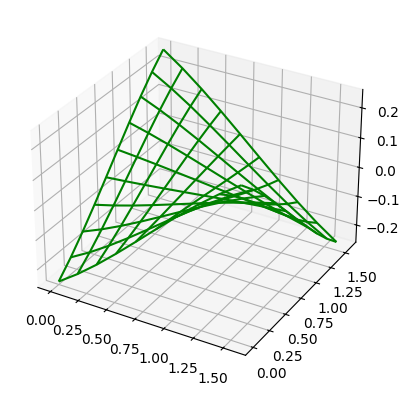

In [51]:
# График разности f(x, y) и f(x)*f(y):

Z = f(X, Y) - multiplied(X, Y)

ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, Z, color='green')

plt.show()

### 2. Найти условные плотности распределения

Условным законом распределения называется распределение одной случайной величины, найденное при условии, что другая случайная величина приняла определенное значение.

In [53]:
f_x_pipe_y_sp = f_sp / f_y_sp
f_y_pipe_x_sp = f_sp / f_x_sp

ipydisplay(Math(f'fₓ(x/y) = {sp.latex(sp.simplify(f_x_pipe_y_sp))}'))
ipydisplay(Math(f'fᵧ(y/x) = {sp.latex(sp.simplify(f_y_pipe_x_sp))}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### 3. Построить гистограммы составляющих двумерной НСВ и графики их плотностей распределения в одной системе координат

In [74]:
# Функция для генерации выборки по функции плотности:

sample_size = 1_000_000

def generate_sample(pdf_bundle: Pdf2dBundle, sample_size=sample_size):
    sample = []
    while len(sample) < sample_size:
        x = pdf_bundle.x1 + rand() * (pdf_bundle.x2 - pdf_bundle.x1)
        y = pdf_bundle.y1 + rand() * (pdf_bundle.y2 - pdf_bundle.y1)
        z = rand()
        if z < pdf_bundle.pdf(x, y):
            sample.append((x, y))
    return sample

In [75]:
# Построение выборки:

sample = generate_sample(f_bundle)
x_sample = [el[0] for el in sample]
y_sample = [el[1] for el in sample]

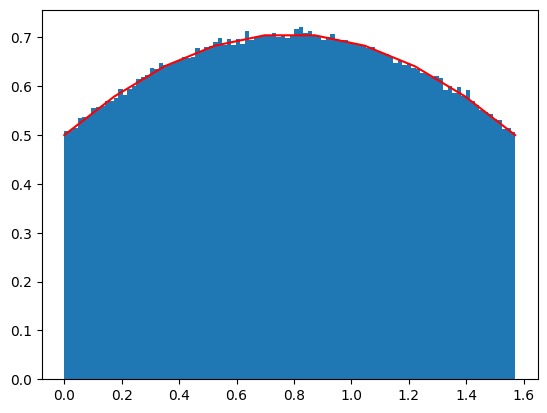

In [76]:
# Построение гистограммы для иксов:

plt.hist(
    x_sample,
    density=True,
    bins=100,
)
plt.plot(
    x_list,
    f_x(x_list),
    color='red'
)
plt.show()

In [78]:
plt.clf()

<Figure size 640x480 with 0 Axes>

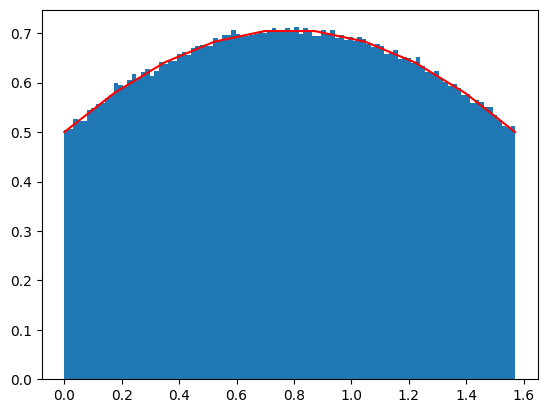

In [81]:
# Построение гистограммы для игреков:

plt.hist(
    y_sample,
    density=True,
    bins=100,
)
plt.plot(
    y_list,
    f_y(y_list),
    color='red'
)
plt.show()

### 5. Вычислить теоретические, точечные и интервальные значения характеристик двумерной НСВ

- математическое ожидание
- дисперсия
- коэффициент корреляции
- доверительные интервалы для математического ожидания
- доверительные интервалы для дисперсии

In [84]:
# Ожидаемое и наблюдаемое математическое ожидание:

expected_mean = (
    scipy.integrate.dblquad(
        lambda x, y: x * f(x, y),
        f_bundle.x1, f_bundle.x2,
        f_bundle.y1, f_bundle.y2
    )[0],
    scipy.integrate.dblquad(
        lambda x, y: y * f(x, y),
        f_bundle.x1, f_bundle.x2,
        f_bundle.y1, f_bundle.y2
    )[0]
)
observed_mean = (
    np.mean(x_sample),
    np.mean(y_sample),
)

print(f'expected mean: {expected_mean}')
print(f'observed mean: {observed_mean}')

expected mean: (0.7853981633974483, 0.7853981633974483)
observed mean: (0.7850698915407496, 0.7853045238319128)


In [86]:
# Ожидаемая и наблюдаемая дисперсия:

expected_variance = (
    scipy.integrate.dblquad(
        lambda x, y: (x - expected_mean[0])**2 * f(x, y),
        f_bundle.x1, f_bundle.x2,
        f_bundle.y1, f_bundle.y2,
    )[0],
    scipy.integrate.dblquad(
        lambda x, y: (y - expected_mean[1])**2 * f(x, y),
        f_bundle.x1, f_bundle.x2,
        f_bundle.y1, f_bundle.y2,
    )[0],
)

observed_variance = (
    np.var(x_sample),
    np.var(y_sample),
)

print(f'expected variance: {expected_variance}')
print(f'observed variance: {observed_variance}')

expected variance: (0.18764660186298152, 0.18764660186298154)
observed variance: (0.18773738417191088, 0.18778142597276762)


Ковариация представляет собой математическое ожидание произведения центрированных случайных величин X и Y и характеризует степень линейной статистической зависимости величин X и Y и рассеивание относительно точки (mx, my): 

Kxy = ∫∫(xi − mx)(yj − my)f(x, y)dxdy

r = Kxy / (sqrt(D(x)) * sqrt(D(y)))

In [109]:
# Ожидаемая корреляция:

expected_r_xy = scipy.integrate.dblquad(
    lambda x, y: ((x - expected_mean[0]) *
                  (y - expected_mean[1]) *
                  f(x, y)),
    f_bundle.x1, f_bundle.x2,
    f_bundle.y1, f_bundle.y2,
)[0] / np.sqrt(expected_variance[0] * expected_variance[1])

# Наблюдаемая корреляция (формула Пирсона):

x_sample_centered = x_sample - observed_mean[0]
y_sample_centered = y_sample - observed_mean[1]

observed_r_xy = ((x_sample_centered @ y_sample_centered)
                 / (len(x_sample)
                    * np.sqrt(observed_variance[0]
                              * observed_variance[1])))

print(f'expected r_xy: {expected_r_xy}')
print(f'observed r_xy: {observed_r_xy}')

expected r_xy: -0.245429162137541
observed r_xy: -0.24761419866683365


In [91]:
gamma = 0.95 # уровень доверия
hypothesis_error_value = 0.05

# confidence interval
def get_delta(offset):
    t = norm.ppf(gamma / 2 + 0.5) # дает квантиль для доверительного интервала
    return t * offset / np.sqrt(sample_size)
    
def get_offset_delta(test_offset): # build confidence level (хи квадрат)
    alphas = ((1 - gamma) / 2, (1 + gamma) / 2)
    chis = (chi2.isf(alphas, sample_size - 1)) # квантили для хвостов
    temp = np.sqrt(sample_size - 1) * test_offset # масштабирование
    
    return (temp / np.sqrt(chis[0]), temp / np.sqrt(chis[1])) # границы интервала

In [97]:
theoretical_std_deviation_x = expected_variance[0]**0.5
delta_x = get_delta(theoretical_std_deviation_x)

theoretical_std_deviation_y = expected_variance[1]**0.5
delta_y = get_delta(theoretical_std_deviation_y)

observed_std_deviation_x = observed_variance[0]**0.5
offset_delta_x = get_offset_delta(observed_std_deviation_x)

observed_std_deviation_y = observed_variance[1]**0.5
offset_delta_y = get_offset_delta(observed_std_deviation_y)

print(f'confidence interval x for mean: {observed_mean[0]-delta_x, observed_mean[0]+delta_x}')
print(f'confidence interval y for mean: {observed_mean[1]-delta_y, observed_mean[1]+delta_y}')

print(f'confidence interval x for variance: {np.square(offset_delta_x)}')
print(f'confidence interval y for variance: {np.square(offset_delta_y)}')

confidence interval x for mean: (0.7842208705198674, 0.7859189125616317)
confidence interval y for mean: (0.7844555028110307, 0.786153544852795)
confidence interval x for variance: [0.1872181  0.18825885]
confidence interval y for variance: [0.18726202 0.18830301]


## Задание 2

Написать программу, реализующую метод формирования двумерной ДСВ. Матрицу распределения ДСВ задаете самостоятельно.

Выполнить статистическое исследование:
1. Проверить составляющие двумерной ДСВ на независимость;
2. Найти условные плотности распределения;
3. Построить гистограммы составляющих двумерной ДСВ;
4. *Построить гистограмму распределения двумерной ДСВ (3D-график);
5. Вычислить теоретические, точечные и интервальные значения характеристик двумерной ДСВ (математическое ожидание, дисперсия, корреляция);
6. *Проверить статистические гипотезы о соответствии полученных оценок характеристик (математическое ожидание, дисперсия, корреляция) случайной величины теоретическим.

In [102]:
X = [1, 2, 3, 4, 5]
Y = [10, 20, 30, 40, 50]
P = [
        [0, 0, 0.05, 0.05, 0.1],
        [0.025, 0.025, 0.025, 0.025, 0.04],
        [0.05, 0.025, 0, 0, 0.1],
        [0.11, 0.07, 0.03, 0.05, 0.055],
        [0.070, 0.05, 0.05, 0, 0]
]

# Вычисление маргинальных распределений
p_x = [sum(row) for row in P]
p_y = [sum(y) for y in zip(*P)]

# Вычисление условных плотностей распределения
p_yi = [[y / p_x[i] for y in row] for i, row in enumerate(P)]

# Считаем кумулятивную сумму (значения функции распределения)
F_x = np.cumsum(p_x)
F_y = [np.cumsum(p_yi[i]) for i in range(len(Y))]


[array([0.  , 0.  , 0.25, 0.5 , 1.  ]), array([0.17857143, 0.35714286, 0.53571429, 0.71428571, 1.        ]), array([0.28571429, 0.42857143, 0.42857143, 0.42857143, 1.        ]), array([0.34920635, 0.57142857, 0.66666667, 0.82539683, 1.        ]), array([0.41176471, 0.70588235, 1.        , 1.        , 1.        ])]


In [107]:
def get_var_and_index(x, F_x, p):
    '''
    Проходит по списку кумулятивных сумм F_x и 
    находит первый элемент, который больше или равен заданной вероятности p.
    Возвращает значение случайной величины (X или Y) 
    и индекс этого значения в списке.
    '''
    return next((x[i], i) for i, p_ in enumerate(F_x) if p_ >= p)

n = 10000

x_l, y_l = [], []
for _ in range(n):
    x, i = get_var_and_index(X, F_x, rand())
    x_l.append(x)
    y_l.append(get_var_and_index(Y, F_y[i], rand())[0])
    
p_x_imp = [x_l.count(X[i]) / n for i in range(len(X))]
p_y_imp = [y_l.count(Y[i]) / n for i in range(len(Y))]

In [105]:
r_theo = lambda M_xy, M_x, M_y, D_x, D_y: (M_xy - M_x * M_y) / math.sqrt(D_x * D_y)


M_f = lambda v, p_v: sum([v[i] * p_v[i] for i in range(len(v))])

def D_f(v, p_v, M=None):
    if M is None:
        M = M_f(v, p_v)
    return sum([(v[i] ** 2) * p_v[i] for i in range(len(v))]) - M ** 2

M_x = M_f(X, p_x)
M_y = M_f(Y, p_y)
M_xy = sum([
    sum([x * y * P[i][j] for j, y in enumerate(Y)])
    for i, x in enumerate(X)
])
D_x = D_f(X, p_x, M_x)
D_y = D_f(Y, p_y, M_y)

print('Теоретические характеристики')
print('M[x] =', M_x, 'D[x] =', D_x)
print('M[y] =', M_y, 'D[y] =', D_y)
print('r[xy] =', r_theo(M_xy, M_x, M_y, D_x, D_y))
print()
print('Эмпирические характеристики')
print('M[x] =', M_f(X, p_x_imp), 'D[x] =', D_f(X, p_x_imp))
print('M[y] =', M_f(Y, p_y_imp), 'D[y] =', D_f(Y, p_y_imp))
print('r =', stats.pearsonr(x_l, y_l)[0])


Теоретические характеристики
M[x] = 3.115 D[x] = 1.9217749999999985
M[y] = 30.35 D[y] = 249.37749999999994
r[xy] = -0.47690403306892665

Эмпирические характеристики
M[x] = 3.1295 D[x] = 1.946129749999999
M[y] = 30.035 D[y] = 249.888775
r = -0.48858391551240765


In [110]:
def draw_plot(v, p_v, p_v_imp, var_name):
    plt.plot(v, p_v, label='theoretical', color='gray', alpha=0.5, ls='--')
    plt.plot(v, p_v_imp, label=f'imperical', color='r', alpha=0.5)
    plt.title(f'{var_name} histogram')
    plt.legend()
    plt.show()

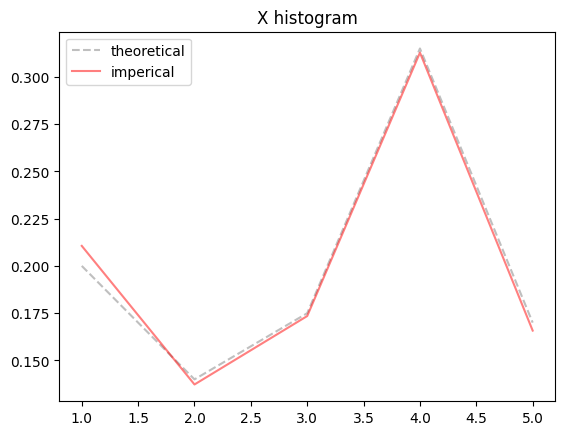

In [111]:
draw_plot(X, p_x, p_x_imp, 'X')

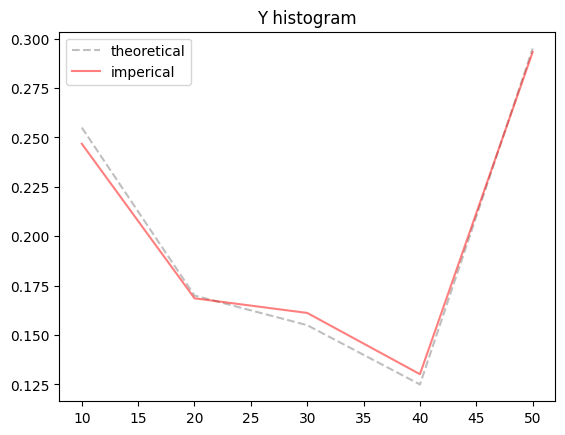

In [112]:
draw_plot(Y, p_y, p_y_imp, 'Y')

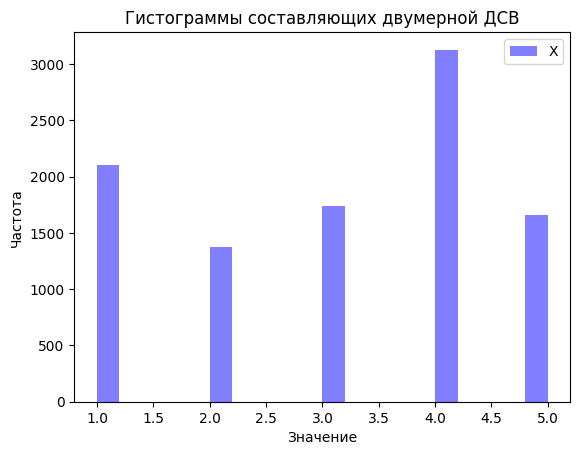

In [113]:
plt.hist(x_l, bins=20, alpha=0.5, color='b', label='X')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.legend()
plt.title('Гистограммы составляющих двумерной ДСВ')
plt.show()

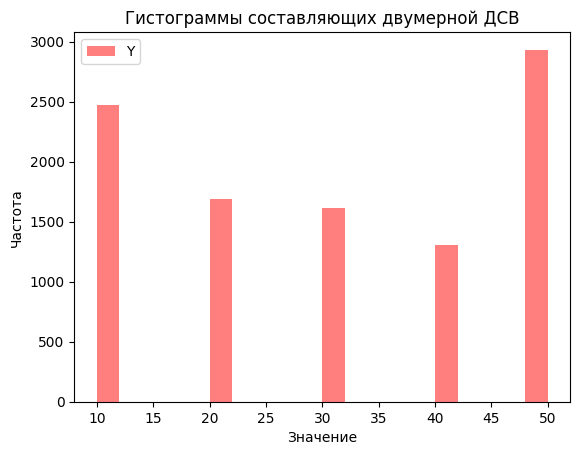

In [114]:
plt.hist(y_l, bins=20, alpha=0.5, color='r', label='Y')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.legend()
plt.title('Гистограммы составляющих двумерной ДСВ')
plt.show()

In [116]:
independent = True
for i in range(len(X)):
    for j in range(len(Y)):
        joint_prob = P[i][j]
        marginal_prob = p_x[i] * p_y[j]
        if not np.isclose(joint_prob, marginal_prob):
            independent = False
            break
    if not independent:
        break

if independent:
    print("Компоненты X и Y независимы")
else:
    print("Компоненты X и Y не являются независимыми")

Компоненты X и Y не являются независимыми


In [118]:
def conditional_density_X_given_Y(y):
    index_y = Y.index(y)
    conditional_probs = [P[index_y][i] / p_y[index_y] for i in range(len(X))]
    return conditional_probs

def conditional_density_Y_given_X(x):
    conditional_probs = [P[i][X.index(x)] / p_x[i] if x in X else 0 for i in range(len(Y))]
    return conditional_probs


# Найти условную плотность P(X|Y=30) и P(Y|X=3)
conditional_density_X_given_Y_30 = conditional_density_X_given_Y(30)
conditional_density_Y_given_X_3 = conditional_density_Y_given_X(3)

print("Условная плотность P(X|Y=30):", conditional_density_X_given_Y_30)
print("Условная плотность P(Y|X=3):", conditional_density_Y_given_X_3)

Условная плотность P(X|Y=30): [0.32258064516129026, 0.16129032258064513, 0.0, 0.0, 0.6451612903225805]
Условная плотность P(Y|X=3): [0.25, 0.17857142857142858, 0.0, 0.09523809523809523, 0.29411764705882354]
